In [1]:
# Implements an optimization proceedure 
# that does not require computing gradients.
# It is based on a gradient free inverse function
# approximation algorithm for univariate functions.
# I test it here on the prime number classification
# problem. For all numbers up to 31. The dataset
# here is pretty small but the model is 100,000 
# parameters or so. I get convergence to about 
# 10^{-6} error in about 25,000 function evaluations
# Results vary from run to run

import numpy as np
import copy
np.random.seed()

# Lets test our optimizer on mnist
import pandas as pd

X = pd.read_csv("../mnist_train_0.csv").values;
print(np.shape(X))
Xcopy = copy.copy(X);

Y = Xcopy[:50000,0]
X = Xcopy[:50000,1:]/255;

Ytest = Xcopy[50000:,0]
Xtest = Xcopy[50000:,1:]/255;

#X = [];
#X.append([0,0,0,0,1])
#X.append([0,0,0,1,0])
#X.append([0,0,0,1,1])
#X.append([0,0,1,0,0])
#X.append([0,0,1,0,1])
#X.append([0,0,1,1,0])
#X.append([0,0,1,1,1])
#X.append([0,1,0,0,0])
#X.append([0,1,0,0,1])
#X.append([0,1,0,1,0])
#X.append([0,1,0,1,1])
#X.append([0,1,1,0,0])
#X.append([0,1,1,0,1])
#X.append([0,1,1,1,0])
#X.append([0,1,1,1,1])
#X.append([1,0,0,0,0])
#X.append([1,0,0,0,1])
#X.append([1,0,0,1,0])
#X.append([1,0,0,1,1])
#X.append([1,0,1,0,0])
#X.append([1,0,1,0,1])
#X.append([1,0,1,1,0])
#X.append([1,0,1,1,1])
#X.append([1,1,0,0,0])
#X.append([1,1,0,0,1])
#X.append([1,1,0,1,0])
#X.append([1,1,0,1,1])
#X.append([1,1,1,0,0])
#X.append([1,1,1,0,1])
#X.append([1,1,1,1,0])
#X.append([1,1,1,1,1])

#X=np.array(X)
#Y=np.array([1,1,1,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1])
W1 = (np.random.random((100,784))-.5)/10
W2 = (np.random.random((100,100))-.5)/10
W4 = (np.random.random((100,100))-.5)/10
W3 = (np.random.random((1,100))-.5)/10

def printar(x):
    theS = "[";
    for i in range(0,np.shape(x)[0]):
        theS=theS+"[";
        for j in range(0,np.shape(x)[1]):
            theS=theS+str(x[i,j])+",";
        theS=theS+"]\n";
    theS =theS+"]";
    print(theS)
        
def sigmoid(x):
    return 1/(1+np.exp(-x));

def relu(x):
    return x*(x>=0)

def forwardpass(X,Y,W1,W2,W3,W4):
    ans = 0
    #for i in range(0,np.shape(X)[0]):
    #    h1 = relu(np.dot(W1,X[i,:]));
    #    h2 = relu(np.dot(W2,h1));
    #    #h3 = relu(np.dot(W4,h2));
    #    #h4 = np.dot(W3,h3);
    #    h4 = np.dot(W3,h2);
    #    ans += (h4[0]-Y[i])**2
    h1 = relu(np.dot(W1,X.T));
    h2 = relu(np.dot(W2,h1));
    h4 = np.dot(W3,h2);
    ans = np.mean((h4 - Y)**2)
    return ans, h4;
    
import bisect

def nnFunct(x):
    global X
    global Y
    global W1
    global W2
    global W3
    global W4
    global dW1
    global dW2
    global dW3
    global dW4
    return forwardpass(X,Y,W1+x*dW1,W2+x*dW2,W3+x*dW3,W4+dW4*x)[0];

# This function implements a gradient 
# free optimization proceedure for a function
# Of one variable. forward is a function
# pointer, and inverse is an array that 
# stores visited points that parameterizes
# our inverse function approximation
# target is the value we are trying to reach
# with the univariate function, step=0 means
# we will try to go directly to the target, step>0
# means we will take a step of size step toward
# the target. Inverse is assumend to be sorted in 
# order of distance to the target.

def tempF(x):
    return (np.exp(x)-1)**2 + np.sin(x) - x**3;
    #return -np.sin(x)+3*np.sin(2*x)-2*np.sin(3*x)+5*np.sin(4*x)+np.sin(5*x);#+np.sin(5*x);

def tempF2(x):
    return np.sin(x);
    
    
def gradFreeOpt(forward, inverse, target=0, step=0.01, randomError=.005):
    # Gets the two closes points to the target and interpolates
    # the inverse function by these points with a line. Gets estimate
    # of input to get target output
    
    # Get current best:
    current = inverse[0,1]
    # get next target
    if step > 0 and step < np.abs(target-current):
        if target < current:
            nextT = -step + current
        if target >=current:
            nextT = current + step
    else:
        nextT = target
    # Compute g inverse estimation
    bob = np.array([[inverse[0,0]**2,inverse[0,0],1],[inverse[1,0]**2,inverse[1,0],1],[inverse[2,0]**2,inverse[2,0],1]])
    sally = np.linalg.solve(bob,inverse[:,1]);
    # If nextT is reachable, since our inverse function approximation is
    # a quadratic function, nextT will be reached at 2 different locations
    # we choose the one closest to the center of our three reference points
    quot = sally[1]**2-(4*sally[0]*(sally[2]-nextT));
    if quot > 0:
        pos = (-sally[1]+np.sqrt(quot))/(2*sally[0])
        neg = (-sally[1]-np.sqrt(quot))/(2*sally[0])
        if np.abs(pos-np.mean(inverse[:,0]))<np.abs(neg-np.mean(inverse[:,0])):
            est =pos;
        else:
            est = neg;
    else:
        # If not reachable set the estimation to the 
        # critical point
        est = -sally[1]/(2*sally[0])
    #slope=(inverse[1,0]-inverse[0,0])/(inverse[1,1]-inverse[0,1])
    #est = slope*(nextT-inverse[0,1])+inverse[0,0]
    
    #print("estimation: "+str(est));
    r=(np.random.randn(1)-.5)*randomError;
    prop = forward(est+r);
    #print("True forward: "+str(prop));
    if np.abs(target -prop) < np.abs(inverse[0,1]-target):
        inverse[1,:]=inverse[0,:];
        inverse[0,:]=[est+r,prop];
    elif np.abs(target-prop) > np.abs(inverse[0,1]-target) and np.abs(target-prop) < np.abs(inverse[1,1]-target):
        inverse[2,:]=inverse[1,:]
        inverse[1,:]=[est+r,prop]
    else :
        inverse[2,:]=[est+r,prop];
    #printar(inverse)
    return inverse



print(str(tempF(-1)));
print(str(tempF(1)));

dW1 = (np.random.random(np.shape(W1))-.5)/10
dW2 = (np.random.random(np.shape(W2))-.5)/10
dW3 = (np.random.random(np.shape(W3))-.5)/10
dW4 = (np.random.random(np.shape(W4))-.5)/10
inverse=np.array([[.05,nnFunct(.05)],[-.01,nnFunct(-.01)],[-.05,nnFunct(-.05)]])
printar(inverse)
inverse=inverse[inverse[:,1].argsort()]
fnew = inverse[0,1];
fsum = 0;
printar(inverse)


iterations = 0;
if False:
    #temp = copy.copy(Xcopy[:50000,:])
    functevals=0
    incredenter = 0;
    while np.abs(inverse[0,1]-0) >= .00001 and functevals<100000:
        # + .9*inverse[0,0]*dW is a momentum term
        #if incredenter % 5 == 0:
        #    np.random.shuffle(temp);
        #incredenter = incredenter % 5;
        #X = temp[10000*incredenter:10000*(incredenter + 1),1:]/255;
        #Y = temp[10000*incredenter:10000*(incredenter + 1),0]
        # We want to develope a way to pick good directions of weight updates to
        # explore. What we have is a series of Weights and function evaluations for
        # each weights. We will try to use these to decide which direction to go to next
        # We will go in the direction deltaW = lambda * (rand) + (1 - lambda) S where
        # 0 <  lambda <= 1, ||rand|| = 1, ||S|| = 1, rand is a random direction, and 
        # S is computed as follows: Normalized: S = sum_{i=1}^{n-1}(W_i - W_n)e^{f(W_i)}/(sum_{i=1}^{n-1}e^{f(W_i)})
        # There is a way to compute S while only storing W_{n-1}, W_n and sum_{i=1}^{n-1}e^{f(W_i)} and e^{f(W_1)}.
        gamma = 0;
        if functevals== 0:
            dont = 0;
        dW1 = (np.random.random(np.shape(W1))-.5)/10 + gamma*dont*inverse[0,0]*dW1
        dW2 = (np.random.random(np.shape(W2))-.5)/10 + gamma*dont*inverse[0,0]*dW2
        dW3 = (np.random.random(np.shape(W3))-.5)/10 + gamma*dont*inverse[0,0]*dW3
        dW4 = (np.random.random(np.shape(W4))-.5)/10 + gamma*dont*inverse[0,0]*dW4
        dont = 1;
        best2=inverse[0,1];
        abB=np.abs(best2)
        if abB >.05:
            abB=.05
        inverse=np.array([[abB,nnFunct(abB)],[-abB/5,nnFunct(-abB/5)],[-abB,nnFunct(-abB)]])
        inverse=inverse[inverse[:,1].argsort()]
        functevals += 3;
        step=100000;
        #counter=0;
        for i in range(0,5):
            best=inverse[0,1]
            randomError = np.abs(inverse[0,1])/100;
            #inverse = gradFreeOpt(nnFunct,inverse,0,step=step,randomError=randomError);
            inverse = gradFreeOpt(nnFunct,inverse,0,step=100000,randomError=randomError)
            #if inverse[0,1]==best:
                #counter += 1
            if np.abs(inverse[0,1]) <= .000005:
                break;
            functevals += 1
            #if counter == 15:
                #break
        if np.abs(best2-0)>np.abs(inverse[0,1]-0):
            W1 = W1+inverse[0,0]*dW1;
            W3 = W3+inverse[0,0]*dW3;
            W2 = W2+inverse[0,0]*dW2;
            W4= W4+inverse[0,0]*dW4;
        # Makes S work    
        
        print(inverse[0,1])
        iterations += 1;
        if iterations % 20 == 19:
            print("Yo");
            print(iterations);
            print(functevals);
            print(get_accuracy(X=Xtest,Y=Ytest));
    print(functevals)

(59999, 785)
0.5581054160858315
2.793963426820456
[[0.05,0.10284102533474325,]
[-0.01,0.10273354885092988,]
[-0.05,0.10265434417543522,]
]
[[-0.05,0.10265434417543522,]
[-0.01,0.10273354885092988,]
[0.05,0.10284102533474325,]
]


In [2]:
# Lets test our optimizer on mnist
import pandas as pd

In [3]:
X = pd.read_csv("../mnist_train_0.csv").values;
print(np.shape(X))

(59999, 785)


In [4]:
# NN(W + xdW, optimize w.r.t x);

0

In [5]:
from matplotlib import pyplot as plt

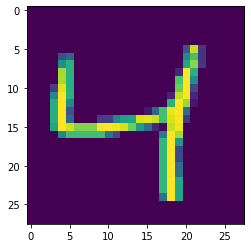

In [6]:
plt.imshow(X[1,1:].reshape(28,28))

In [7]:
Y = X[:,0]
print(Y[:10])

[1 0 0 0 0 0 0 0 0 0]


In [8]:
X = X[:,1:];

In [9]:
Xtest = pd.read_csv("../mnist_test_0.csv").values;
Ytest = Xtest[:,0];
Xtest = Xtest[:,1:];

In [331]:
def get_accuracy(X=X,Y=Y):
    [answ,h] = forwardpass(X,Y,W1,W2,W3,W4);
    yhat = (h > .5)*2 - 1;
    return np.mean((((Y*2 -1) * yhat) > 0));
get_accuracy()

ValueError: shapes (100,784) and (0,) not aligned: 784 (dim 1) != 0 (dim 0)

-1
2
[[-1.0,0.5581054160858315,]
[2.0,33.72933526210862,]
[-6.0,217.27446413805794,]
]
1
0.0
0.5
3.0
0.25
3.0
0.125
4.0
0.0625
4.0
0.03125
4.715
0.015625
5.0
0.0078125
5.185
0.00390625
6.0
0.001953125
6.0


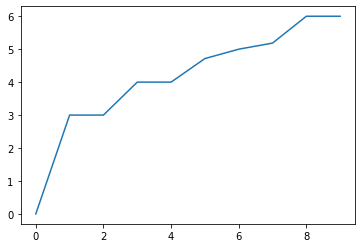

In [292]:
# Here we test how effective our 1D optimizer is by
# considering how many steps it takes to get our optimizer
# to find a solution to some arbitrary accuracy
a = np.random.randint(-12,12);
print(a);
b = np.random.randint(-12,12);
print(b)
c = np.random.randint(-12,12);
inverse=np.array([[a,tempF(a)],[b,tempF(b)],[c,tempF(c)]])
inverse=inverse[inverse[:,1].argsort()]
printar(inverse)
countMeans = [];
for j in range(0,10):
    counts = [];
    for i in range(0,200):
        count = 0;
        inverse=np.array([[1,tempF(1)],[13,tempF(13)],[-1,tempF(-1)]])
        inverse=inverse[inverse[:,1].argsort()]
        while (np.abs(inverse[0,1]) > 2**(-j)):
            randomError = np.abs(inverse[0,1])/100;
            inverse = gradFreeOpt(tempF, inverse, step=100, randomError=randomError)
            count += 1
        #print(count)
        counts.append(count);
    print(2**(-j))
    print(np.mean(counts))
    countMeans.append(np.mean(counts));
plt.plot(countMeans)

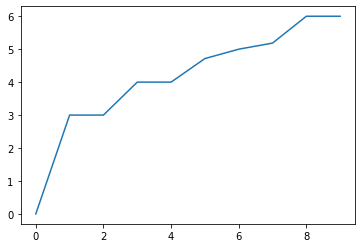

In [293]:
plt.plot(countMeans)

In [294]:
X = np.ones((2,len(countMeans)));
X[0,:] = -np.array(range(2,2+len(countMeans)));
#X[0,:] = np.array(countMeans);

In [295]:
Z = np.dot(X,X.T)

In [296]:
answer = np.linalg.solve(Z,np.dot(X,countMeans));

In [297]:
answer

array([-0.54327273,  0.55872727])

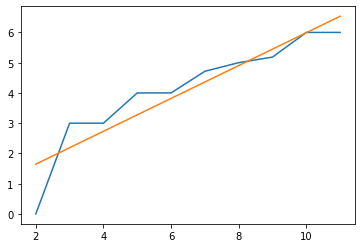

In [299]:
plt.plot(np.array(range(2,2+len(countMeans))),countMeans);
plt.plot(np.array(range(2,2+len(countMeans))),-np.array(range(2,2+len(countMeans)))*answer[0]+answer[1])

In [211]:
X[0,:]

array([ -2.,  -3.,  -4.,  -5.,  -6.,  -7.,  -8.,  -9., -10., -11., -12.,
       -13., -14., -15., -16., -17., -18., -19., -20., -21., -22., -23.,
       -24., -25., -26., -27., -28., -29., -30., -31., -32., -33.])

In [537]:
# |f(W+x*dW) - 2|, with respect to x (univariate optimization problem)
# So many ways to numerically solve problems, here is gradient descent 
# for finding and eigenvector eigenvalue pair, this returns the real
# eigenvector corresponding to the largest eigenvalue
def eignSolve(A,x0,l0,iterNum=1000,stepSize=1):
    x = x0
    l = l0
    for i in range(0,iterNum):
        #xNew = np.dot(2*(np.dot(A.T,A) - l*A.T - l*A+l**2),x)
        #lNew = -np.dot(x,np.dot(2*l-A.T-A,x));
        xNew = np.dot(2*A+2*l,x)
        lNew = -np.dot(x,x)
        x = x - stepSize*xNew;
        x = x/np.linalg.norm(x);
        l = l - stepSize*lNew
    print(x)
    return (x,l)


In [538]:
A = np.random.random((3,3));
A = A + A.T

In [539]:
print(np.shape(A))
x0 = np.random.random(np.shape(A)[0])
l0 = 1;

(3, 3)


In [540]:
(x,l) = eignSolve(A,x0,l0)

[0.57746504 0.57725766 0.57732809]


In [528]:
np.linalg.eig(A)[1][1]

array([-0.70795983,  0.12832718, -0.69449623])

In [488]:
x

array([nan, nan, nan])

In [475]:
x

array([-0.10000093, -0.09999839, -0.10000047, -0.09999981, -0.10000019,
       -0.09999969, -0.10000219, -0.10000009, -0.09999915, -0.09999996,
       -0.10000032, -0.0999994 , -0.09999983, -0.09999975, -0.10000055,
       -0.09999954, -0.10000093, -0.09999977, -0.10000053, -0.1000004 ,
       -0.10000206, -0.10000108, -0.09999917, -0.09999901, -0.09999969,
       -0.10000109, -0.1000017 , -0.09999988, -0.10000021, -0.09999966,
       -0.09999983, -0.09999982, -0.09999868, -0.10000213, -0.0999991 ,
       -0.10000035, -0.09999959, -0.10000018, -0.09999985, -0.09999941,
       -0.09999961, -0.09999893, -0.10000036, -0.09999934, -0.10000002,
       -0.0999994 , -0.09999993, -0.0999991 , -0.10000228, -0.09999899,
       -0.09999965, -0.09999873, -0.09999967, -0.0999986 , -0.09999943,
       -0.09999966, -0.10000023, -0.10000074, -0.09999993, -0.09999826,
       -0.0999999 , -0.09999999, -0.10000174, -0.09999935, -0.10000024,
       -0.10000162, -0.10000091, -0.09999935, -0.09999979, -0.10

In [27]:
# requires a function pointer f, that takes as input 
# the parameters W
def gradFreeOptArb(f,W,step=100000,numIter=10000,numEvals=100000):
    dW = (np.random.random(np.shape(W))-.5)/100;
    def univarF(x):
        return (f(W+x*dW));
    inverse=np.array([[.05,univarF(.05)],[-.01,univarF(-.01)],[-.05,univarF(-.05)]])
    #printar(inverse)
    inverse=inverse[inverse[:,1].argsort()]
    fnew = inverse[0,1];
    fsum = 0;
    printar(inverse)
    iterations = 0;
    functevals=0
    incredenter = 0;
    while np.abs(inverse[0,1]-0) >= .00001 and functevals<numEvals and iterations < numIter:
        # + .9*inverse[0,0]*dW is a momentum term
        #if incredenter % 5 == 0:
        #    np.random.shuffle(temp);
        #incredenter = incredenter % 5;
        #X = temp[10000*incredenter:10000*(incredenter + 1),1:]/255;
        #Y = temp[10000*incredenter:10000*(incredenter + 1),0]
        # We want to develope a way to pick good directions of weight updates to
        # explore. What we have is a series of Weights and function evaluations for
        # each weights. We will try to use these to decide which direction to go to next
        # We will go in the direction deltaW = lambda * (rand) + (1 - lambda) S where
        # 0 <  lambda <= 1, ||rand|| = 1, ||S|| = 1, rand is a random direction, and 
        # S is computed as follows: Normalized: S = sum_{i=1}^{n-1}(W_i - W_n)e^{f(W_i)}/(sum_{i=1}^{n-1}e^{f(W_i)})
        # There is a way to compute S while only storing W_{n-1}, W_n and sum_{i=1}^{n-1}e^{f(W_i)} and e^{f(W_1)}.
        gamma = 0;
        if functevals== 0:
            dont = 0;
        dW = (np.random.random(np.shape(W))-.5)/100 + gamma*dont*inverse[0,0]*dW
        dont = 1;
        best2=inverse[0,1];
        abB=np.abs(best2)
        if abB >.05:
            abB=.05
        inverse=np.array([[abB,univarF(abB)],[-abB/5,univarF(-abB/5)],[-abB,univarF(-abB)]])
        inverse=inverse[inverse[:,1].argsort()]
        functevals += 3;
        #counter=0;
        for i in range(0,5):
            best=inverse[0,1]
            randomError = np.abs(inverse[0,1])/100;
            #inverse = gradFreeOpt(nnFunct,inverse,0,step=step,randomError=randomError);
            inverse = gradFreeOpt(univarF,inverse,0,step=step,randomError=randomError)
            #if inverse[0,1]==best:
                #counter += 1
            if np.abs(inverse[0,1]) <= .000005:
                break;
            functevals += 1
            #if counter == 15:
                #break
        if np.abs(best2-0)>np.abs(inverse[0,1]-0):
            W = W+inverse[0,0]*dW;
        # Makes S work    
        
        #print(inverse[0,1])
        iterations += 1;
        if iterations % 20 == 19:
        #    print("Yo");
        #    print(iterations);
        #    print(functevals);
        #    print(get_accuracy(X=Xtest,Y=Ytest));
            print(functevals)
            print(inverse[0,1])
    return W;

In [75]:
def eignOpt(x):
    x[:] = x[:]/np.linalg.norm(x[:]);
    return 2-np.dot(x[:],np.dot(A+A.T,x[:]))/np.dot(x[:],x[:]);
A = np.random.random((1000,1000));
A = A.T + A;
A = A/np.linalg.norm(A);
x = np.random.random(np.shape(A)[0]);
x = x/np.linalg.norm(x);
x = gradFreeOptArb(eignOpt,x,numIter=10000)

[[0.05,0.6193066531264231,]
[-0.01,0.6194084615239157,]
[-0.05,0.6195195792291439,]
]
152
0.6131132371310541
312
0.6075262983446434
472
0.5976129018897212
632
0.585395443388683
792
0.5711003827122152
952
0.5618474495944159
1112
0.5526881959186682
1272
0.5479903162718605
1432
0.5422026029392601
1592
0.5336869122872319
1752
0.5268834370084399
1912
0.5198243520950783
2072
0.5133543511359033
2232
0.5048377536398987
2392
0.49991306393061885
2552
0.49046107506778225
2712
0.4820571372701208
2872
0.4764782262200684
3032
0.46893594578823294
3192
0.46227955812932486
3352
0.4574877223119731
3512
0.45314208660664357
3672
0.4456935655163543
3832
0.4379201390957399
3992
0.43396184019629325
4152
0.42959410355865635
4312
0.42499562534722024
4472
0.4206225908976242
4632
0.41109501752648825
4792
0.4069352075195294
4952
0.40292559052691557
5112
0.39849902877876
5272
0.39325286800198866
5432
0.3889379970553195
5592
0.38488147191472466
5752
0.37630645003878027
5912
0.37368451680604875
6072
0.36905228498714

51192
0.1490722312910322
51352
0.14905015208409012
51512
0.14903788588162104
51672
0.14900963315912952
51832
0.14899100557903977
51992
0.14898118539398908
52152
0.14896516465322152
52312
0.1489539078337594
52472
0.14894222849323646
52632
0.14893174975404744
52792
0.14891789407372058
52952
0.14890399113516928
53112
0.14888600522199935
53272
0.14888029124108892
53432
0.14887112774633882
53592
0.14885085598030967
53752
0.14884295324773822
53912
0.14883479561275492
54072
0.14881396705950944
54232
0.14880265326399322
54392
0.14879079353778368
54552
0.1487838761041127
54712
0.1487760528220028
54872
0.14876860547209003
55032
0.14875589070939044
55192
0.14874219753005535
55352
0.1487332276822826
55512
0.1487213483616141
55672
0.14871207740755366
55832
0.14869865793833914
55992
0.14869026438333877
56152
0.14868305218401523
56312
0.14867347645397877
56472
0.1486640377008721
56632
0.1486568439964684
56792
0.14864812672650274
56952
0.1486406347674616
57112
0.14863753118251188
57272
0.1486261520955

In [82]:
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
bob = largest_eigsh(A,1)[1]

In [85]:
np.linalg.norm(x/np.linalg.norm(x) + bob/np.linalg.norm(bob))

0.5678468425477097

In [88]:
largest_eigsh(A,1)[0]

array([0.92588284])

In [107]:
A = np.random.random((1000,1000))-.5;
A = A/np.linalg.norm(A);
x = np.random.random(np.shape(A)[0]);
x = x/np.linalg.norm(x);
for i in range(0,1000):
    xNew = np.dot(A,x);
    x = xNew/np.linalg.norm(xNew);

In [108]:
np.dot(A,x)/x

array([-1.23095289e-01,  5.02585314e-02,  1.91980290e-02, -2.23892765e-02,
       -2.05392364e-02,  4.44600049e-02,  1.56595799e-02,  2.12884591e-02,
       -1.87091914e-03,  4.56208078e-02,  1.74207092e-02, -6.10724661e-03,
       -2.75572080e-02, -7.78381241e-02, -1.50597472e+01,  1.35021550e-02,
        3.02025547e-02, -8.88645663e-03,  1.47671540e-02,  8.07100795e-03,
        8.88735702e-02,  1.00936243e-01,  2.27362770e-02,  2.04786793e-02,
        3.21735926e-02,  7.79092657e-02, -1.69230772e-03,  2.98793649e-02,
        1.45889897e-02,  2.75773082e-02,  5.83259841e-02,  3.04151605e-02,
        4.23609086e-02,  1.51429106e-02,  7.38466154e-02,  2.16090722e-03,
        3.30379681e-02,  1.73442120e-02,  1.56924864e-02,  2.70159884e-02,
        5.39026697e-02, -5.28814902e-04,  2.91356821e-02,  5.90883172e-02,
       -5.11424529e-02,  1.93838808e-02,  5.08445393e-03, -7.92124145e-02,
        3.30886408e-01,  2.82824985e-02,  3.33612214e-02, -1.32314570e-01,
       -3.29896356e-01,  